In [91]:
# Load necessary libraries
if (!requireNamespace("readxl", quietly = TRUE)) install.packages("readxl")
if (!requireNamespace("googlesheets4", quietly = TRUE)) install.packages("googlesheets4") # nolint: line_length_linter.

library(readxl)
library(googlesheets4)


In [92]:
# Define input and output paths
input_path <- "https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0" # nolint
output_path <- "https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0" # nolint

local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR.csv" # nolint

regression_df <- read.csv(local_input_path)
print(regression_df)


          date       regiao mental_health_visits total_atd periodo
1   2018-01-01       Brasil               280906  16650688       1
2   2018-02-01       Brasil               268180  15280725       2
3   2018-03-01       Brasil               315705  18712756       3
4   2018-04-01       Brasil               321409  18818333       4
5   2018-05-01       Brasil               325042  19291195       5
6   2018-06-01       Brasil               318899  17535895       6
7   2018-07-01       Brasil               334235  18796956       7
8   2018-08-01       Brasil               387238  21295471       8
9   2018-09-01       Brasil               371794  20066133       9
10  2018-10-01       Brasil               454198  24146684      10
11  2018-11-01       Brasil               349077  18438761      11
12  2018-12-01       Brasil               263849  14059001      12
13  2019-01-01       Brasil               340011  19409656      13
14  2019-02-01       Brasil               369303  20389977    

# Imports

In [93]:
# install.packages(c(
#    "lme4",
#     "performance",
#      "DHARMa",
#      "ggplot2",
#      "ggeffects",
#      "purrr",
#      "emmeans",
#      "performance",
#      "dplyr",
#      "patchwork",
#      "see",
#      "broom.mixed",
#      "dotwhisker",
#      "tidyr",
#      "stringr",
#      "glarma",
#      "brms",
#      "remotes",
#      "tibble"))

# install.packages(c(
#    "dplyr",
#    "nlme",
#    "MASS"
# ))
install.packages(c(
    # "lubridate",
    # "ggplot2",
    "purrr"
))
library(dplyr)
library(MASS)
library(nlme)
library(purrr)
# library(glmmTMB) # For NB GLMM with autocorrelation
# library(lme4) # Alternative for basic GLMM
# library(performance) # For model checks
# library(DHARMa) # For residual diagnostics
# library(ggplot2) # For plots
# library(ggeffects)
# library(purrr)
# library(emmeans)
# library(performance)

# library(patchwork)
# library(see)
# library(broom.mixed)
# library(dotwhisker)
# library(tidyr)
# library(stringr)
# library(glarma)
# library(brms)
# library(remotes)
# library(tibble)


Warning message:
"o pacote 'purrr' está em uso e não será instalado"


In [94]:
options(repr.plot.width = 16, repr.plot.height = 8) # Para Jupyter Notebook/RMarkdown


# Model Defs

In [95]:
#' Fit GLMM with PQL estimation and AR(1) structure
#'
#' @param data Dataframe containing all variables
#' @param response_var Name of response variable (count data)
#' @param fixed_effects Vector of fixed effect variable names
#' @param offset_var Name of offset variable (should be log-transformed)
#' @param time_var Name of time variable for AR(1) structure
#' @param group_var Name of grouping variable (default intercept-only)
#' @param theta Starting value for negative binomial theta (NULL for estimation)
#'
#' @return Fitted model object
#' @export
#'
#' @examples
#' model <- fit_glmm_ar1(
#'   data = my_data,
#'   response_var = "mental_health_visits",
#'   fixed_effects = c("periodo", "Pandemia_Step", "Pandemia_Trend"),
#'   offset_var = "log_total_visits",
#'   time_var = "month"
#' )
fit_glmm_ar1 <- function(data,
                         response_var,
                         fixed_effects,
                         offset_var = NULL,
                         time_var,
                         group_var = NULL,
                         theta = 1) {
  # Load required packages
  require(nlme)
  require(MASS)

  # Create formula components
  fixed_part <- paste(
    response_var, "~",
    paste(fixed_effects, collapse = " + ")
  )

  if (!is.null(offset_var)) {
    fixed_part <- paste(fixed_part, "+ offset(", offset_var, ")")
  }

  # Handle grouping structure
  if (is.null(group_var)) {
    data$..group.. <- factor(1) # Intercept-only random effect
    random_formula <- ~ 1 | ..group..
    cor_formula <- as.formula(paste("~", time_var, "| ..group.."))
  } else {
    random_formula <- as.formula(paste("~ 1 |", group_var))
    cor_formula <- as.formula(paste("~", time_var, "|", group_var))
  }

  # Fit model
  model <- glmmPQL(
    fixed = as.formula(fixed_part),
    random = random_formula,
    family = negative.binomial(theta = theta), # quasipoisson(),#poisson(),#
    correlation = corAR1(form = cor_formula),
    data = data,
    verbose = FALSE
  )


  # Add model components to object for easier reference
  model$call$fixed <- fixed_part
  model$call$random <- random_formula
  model$call$correlation <- cor_formula

  return(model)
}


In [96]:
fit_glmm_arma <- function(data,
                          response_var,
                          fixed_effects,
                          offset_var = NULL,
                          time_var,
                          group_var = NULL,
                          theta = 1,
                          ar_order = 1, # Ordem AR(p)
                          ma_order = 0) { # Ordem MA(q)

  require(nlme)
  require(MASS)
  require(dplyr)

  # Criar fórmula fixa
  fixed_part <- paste(response_var, "~", paste(fixed_effects, collapse = " + "))

  if (!is.null(offset_var)) {
    fixed_part <- paste(fixed_part, "+ offset(", offset_var, ")")
  }

  # Estrutura aleatória
  if (is.null(group_var)) {
    data$..group.. <- factor(1)
    random_formula <- ~ 1 | ..group..
    cor_formula <- as.formula(paste("~", time_var, "| ..group.."))
  } else {
    random_formula <- as.formula(paste("~ 1 |", group_var))
    cor_formula <- as.formula(paste("~", time_var, "|", group_var))
  }

  # Estrutura de correlação ARMA
  if (ar_order > 0 | ma_order > 0) {
    cor_struct <- corARMA(form = cor_formula, p = ar_order, q = ma_order)
  } else {
    cor_struct <- NULL
  }

  # Ajustar modelo
  model <- glmmPQL(
    fixed = as.formula(fixed_part),
    random = random_formula,
    family = negative.binomial(theta = theta),
    correlation = cor_struct,
    data = data,
    verbose = FALSE
  )

  return(model)
}


# Model Run

In [97]:
# Inicialize uma lista para guardar os modelos
models_list <- list()

# Loop para ajustar os modelos por região e armazenar na lista
for (reg in unique(regression_df$regiao)) {
  require(dplyr)
  cat("=============================================Rodando:", reg, "\n")
  reg_data <- regression_df %>% filter(regiao == reg)

  model <- fit_glmm_arma(
    data = reg_data,
    response_var = "mental_health_visits",
    fixed_effects = c(
      "periodo", "Pandemia_Step", "Pandemia_Trend",
      "PosPandemia_Step", "PosPandemia_Trend", "cos1", "sin1"
    ),
    offset_var = "offset",
    time_var = "periodo",
    ar_order = 1,
    ma_order = 1,
  )

  # Armazenar o modelo na lista com a chave sendo a região
  models_list[[reg]] <- model

  # Imprimir o resumo do modelo para verificação
  print(summary(model))
}


=============================================Rodando: Brasil 
Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept)   Residual
StdDev: 8.737024e-07 0.05054082

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
      Phi1     Theta1 
0.07178285 0.42492844 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + cos1 + sin1 + offset(offset) 
                       Value  Std.Error DF  t-value p-value
(Intercept)        2.7988033 0.02829513 64 98.91466  0.0000
periodo            0.0112721 0.00174777 64  6.44941  0.0000
Pandemia_Step      0.1826274 0.03794105 64  4.81345  0.0000
Pandemia_Trend    -0.0150688 0.00275405 64 -5.47151  0.0000
PosPandemia_Step  -0.1773378 0.07287721 64 -2.43338  0.0178
PosPandemia_Tren

# Exportar Coeficients

In [98]:
library(dplyr)
library(purrr)

# Função para extrair coeficientes de um modelo
extract_coefficients <- function(model) {
  # Extrai a tabela de coeficientes
  coef_table <- summary(model)$tTable

  # Converte para dataframe e adiciona nomes das variáveis como coluna
  as.data.frame(coef_table) %>%
    tibble::rownames_to_column("term") %>%
    rename(
      estimate = Value,
      std.error = Std.Error,
      t.value = `t-value`,
      p.value = `p-value`
    )
}

# Extrai todos os coeficientes para cada região
coef_list <- imap(models_list, ~ {
  extract_coefficients(.x) %>%
    mutate(region = .y) # Adiciona nome da região como coluna
})

# Combina todos os resultados em um único dataframe
all_coefficients <- bind_rows(coef_list)

# Salva como CSV
write.csv(all_coefficients, "model_coefficients.csv", row.names = FALSE)

# Visualização dos primeiros resultados (opcional)
head(all_coefficients)


,term,estimate,std.error,DF,t.value,p.value,region
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,(Intercept),2.798803267,0.028295131,64,98.914662,1.020922e-71,Brasil
2,periodo,0.011272099,0.001747772,64,6.449409,1.702293e-08,Brasil
3,Pandemia_Step,0.182627414,0.037941045,64,4.813452,9.427070e-06,Brasil
4,Pandemia_Trend,-0.015068819,0.002754052,64,-5.471508,7.930263e-07,Brasil
5,PosPandemia_Step,-0.177337788,0.072877212,64,-2.433378,1.776207e-02,Brasil
6,PosPandemia_Trend,0.001852593,0.003057992,64,0.605820,5.467769e-01,Brasil


# Diagnóstico

In [99]:
# Criar pastas para salvar os resultados
if (!dir.exists("acf_plots")) {
  dir.create("acf_plots")
}
if (!dir.exists("model_tests")) {
  dir.create("model_tests")
}

# Arquivo para salvar os testes Ljung-Box
sink(file = "model_tests/ljung_box_results.txt")

# Loop através de cada modelo na lista
for (reg in names(models_list)) {
  model <- models_list[[reg]]

  # Extrair resíduos normalizados
  res <- residuals(model, type = "normalized")

  # Gráficos ACF/PACF
  png(
    filename = paste0("acf_plots/", reg, "_acf_pacf.png"),
    width = 10, height = 5, units = "in", res = 300
  )
  par(mfrow = c(1, 2))

  # Plot ACF
  acf(res,
    main = paste("ACF -", reg),
    lag.max = 36,
    ylim = c(-0.5, 1)
  )

  # Plot PACF
  pacf(res,
    main = paste("PACF -", reg),
    lag.max = 36,
    ylim = c(-0.5, 1)
  )

  dev.off()

  # Teste Ljung-Box para diferentes lags
  cat("\n----------------------------------------\n")
  cat("Região:", reg, "\n")
  cat("Testes Ljung-Box para resíduos:\n\n")

  # Testar para lags específicos (1, 9, 12, 24, 25)
  for (lag in c(1, 9, 12, 24, 25)) {
    test <- Box.test(res, lag = lag, type = "Ljung-Box")
    cat(sprintf("Lag %2d: p-valor = %.4f", lag, test$p.value))

    # Adicionar asterisco para significância
    if (test$p.value < 0.05) {
      cat(" *")
      if (test$p.value < 0.01) cat("*")
      if (test$p.value < 0.001) cat("*")
    }
    cat("\n")
  }

  # Mostrar mensagem de progresso
  cat("Gráficos e testes gerados para:", reg, "\n")
}

# Fechar o arquivo de saída
sink()


# Plot

Plotando: Brasil 
Plotando: centro_oeste 


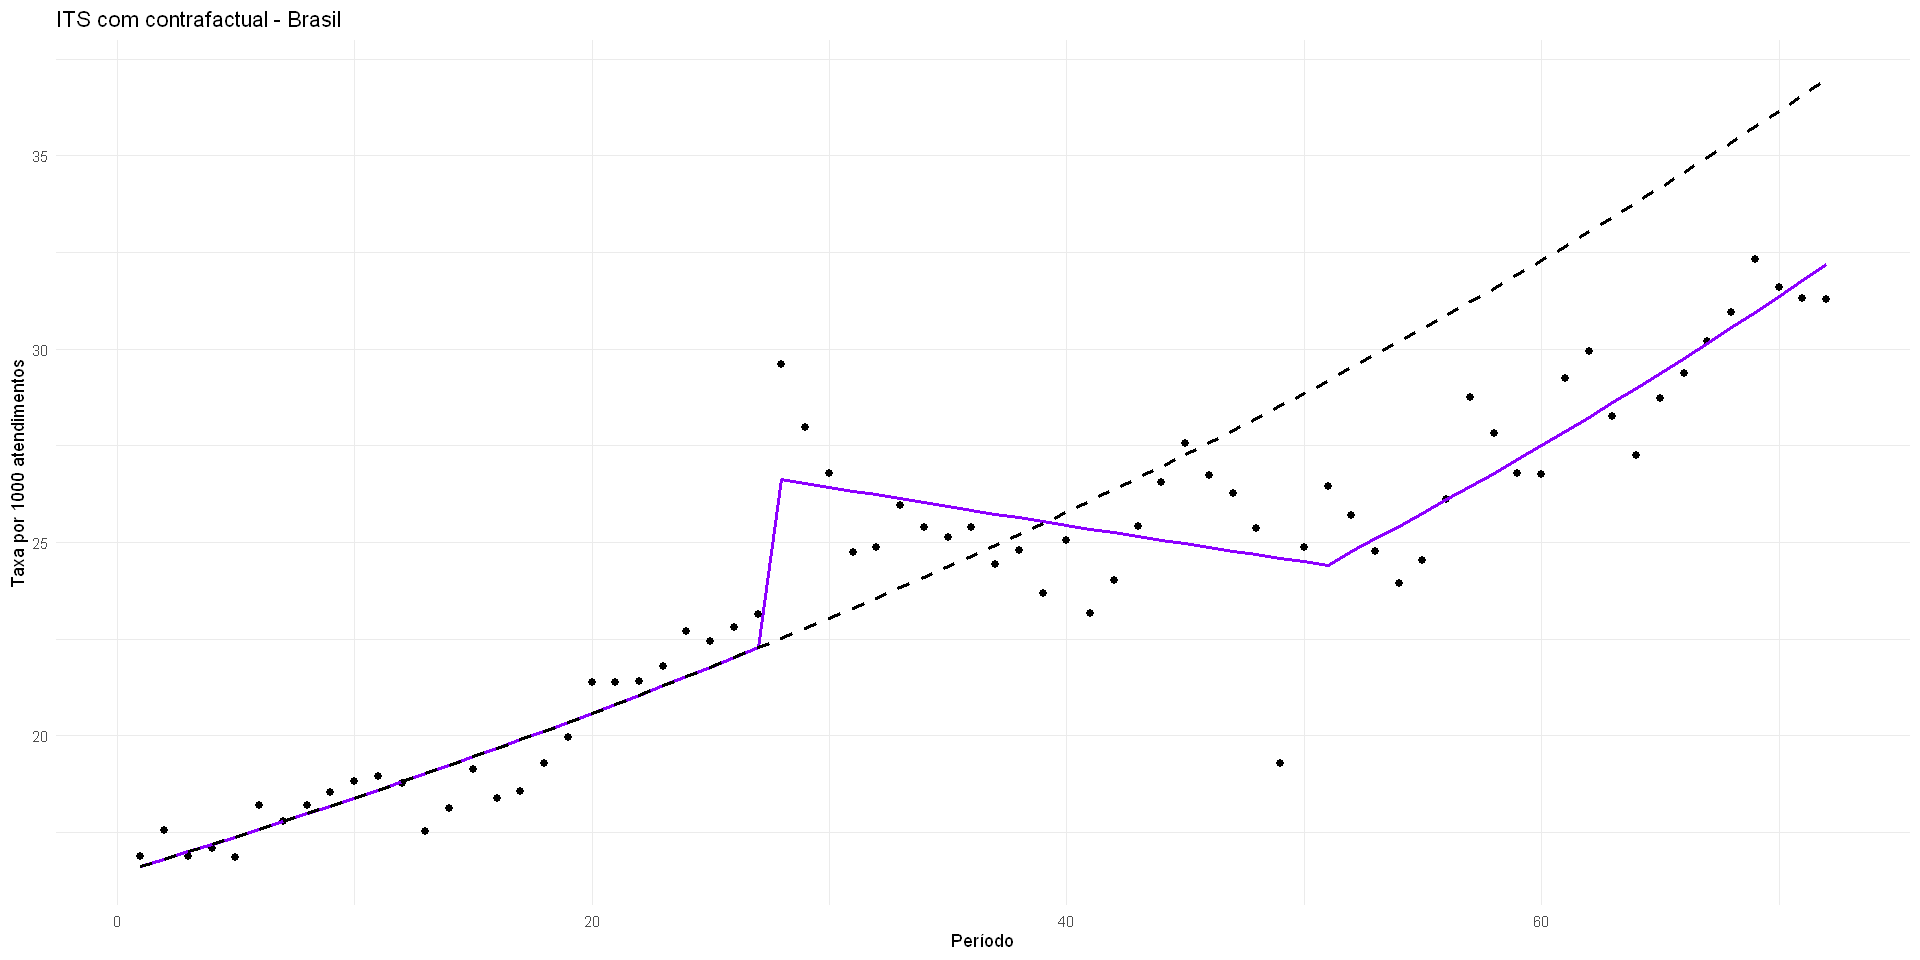

Plotando: nordeste 


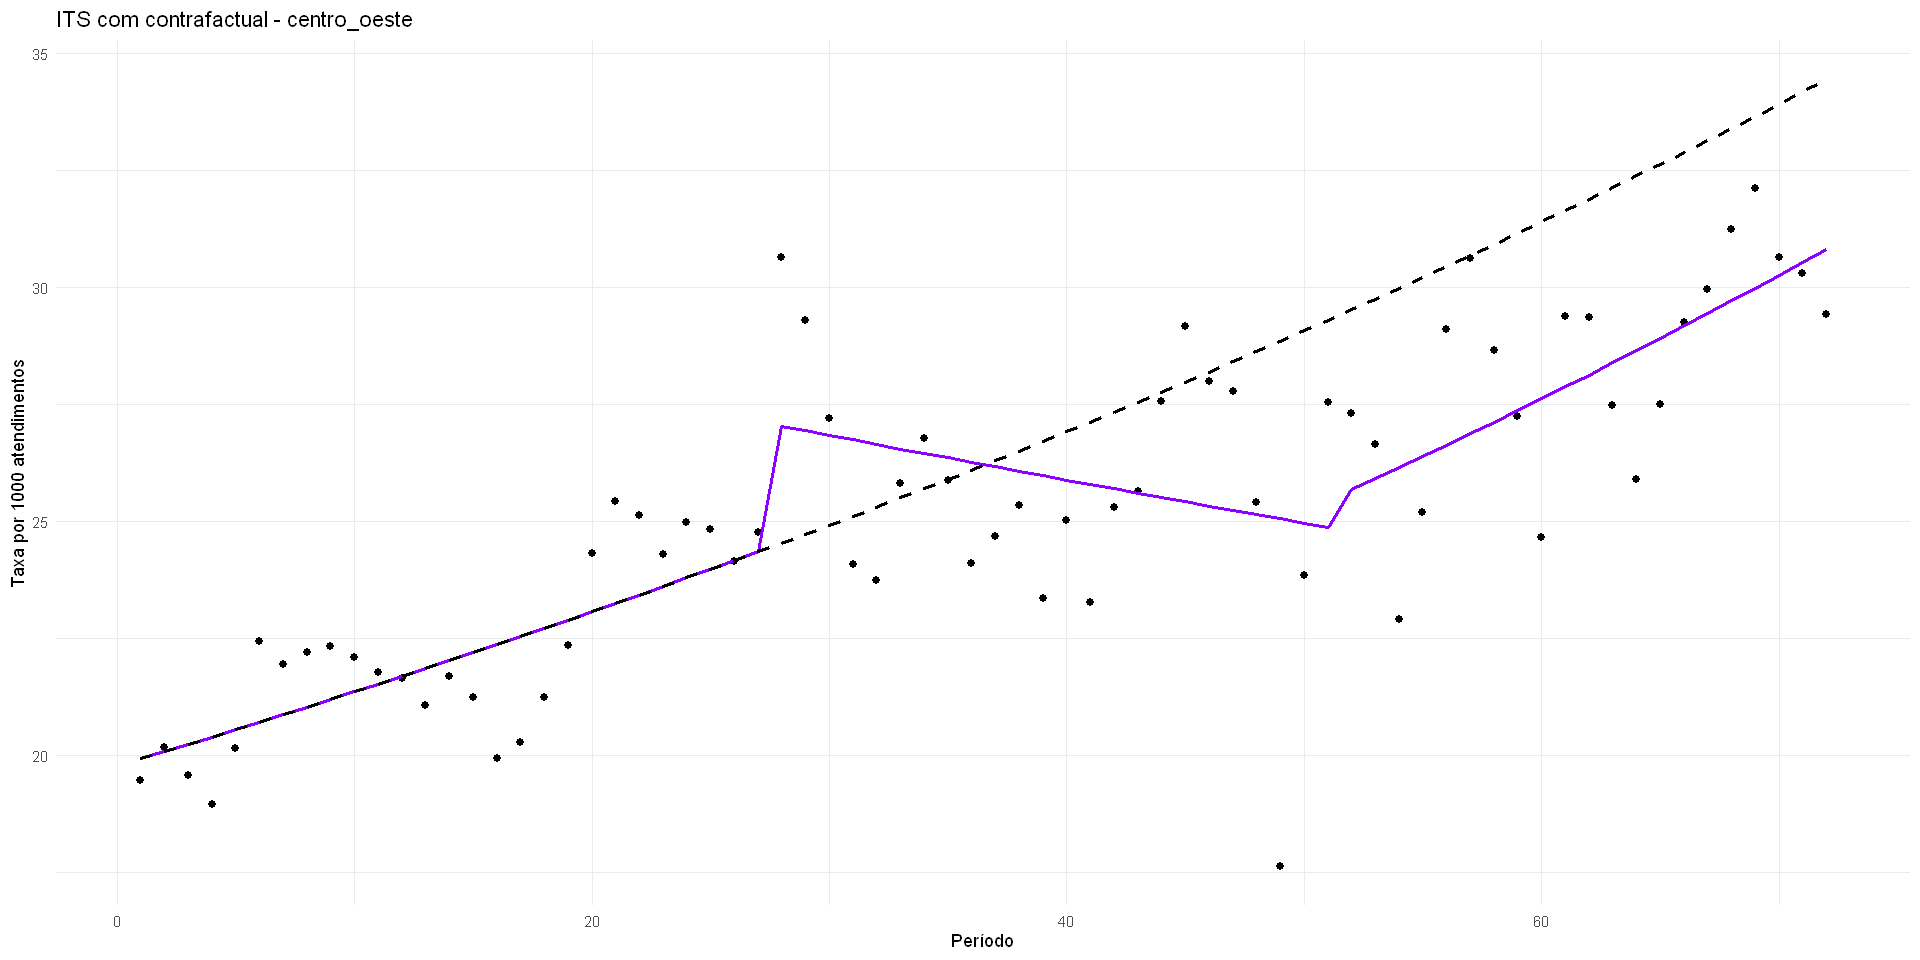

Plotando: norte 


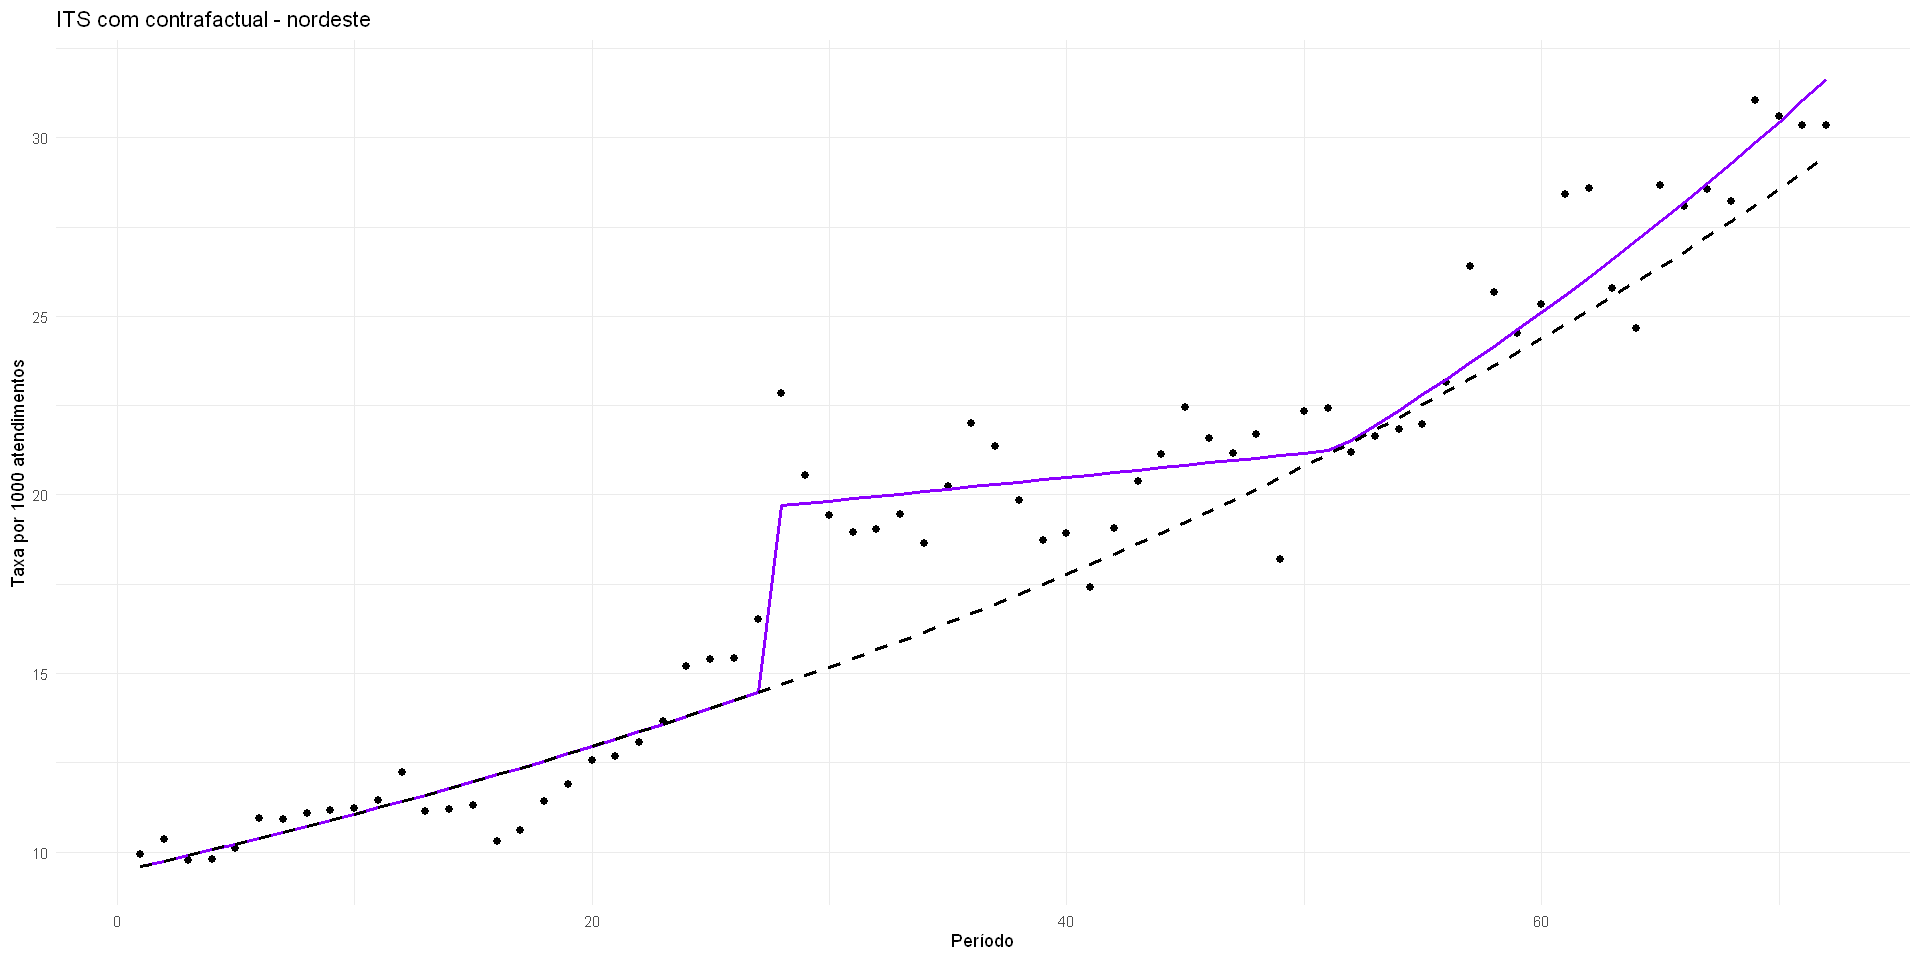

Plotando: sudeste 


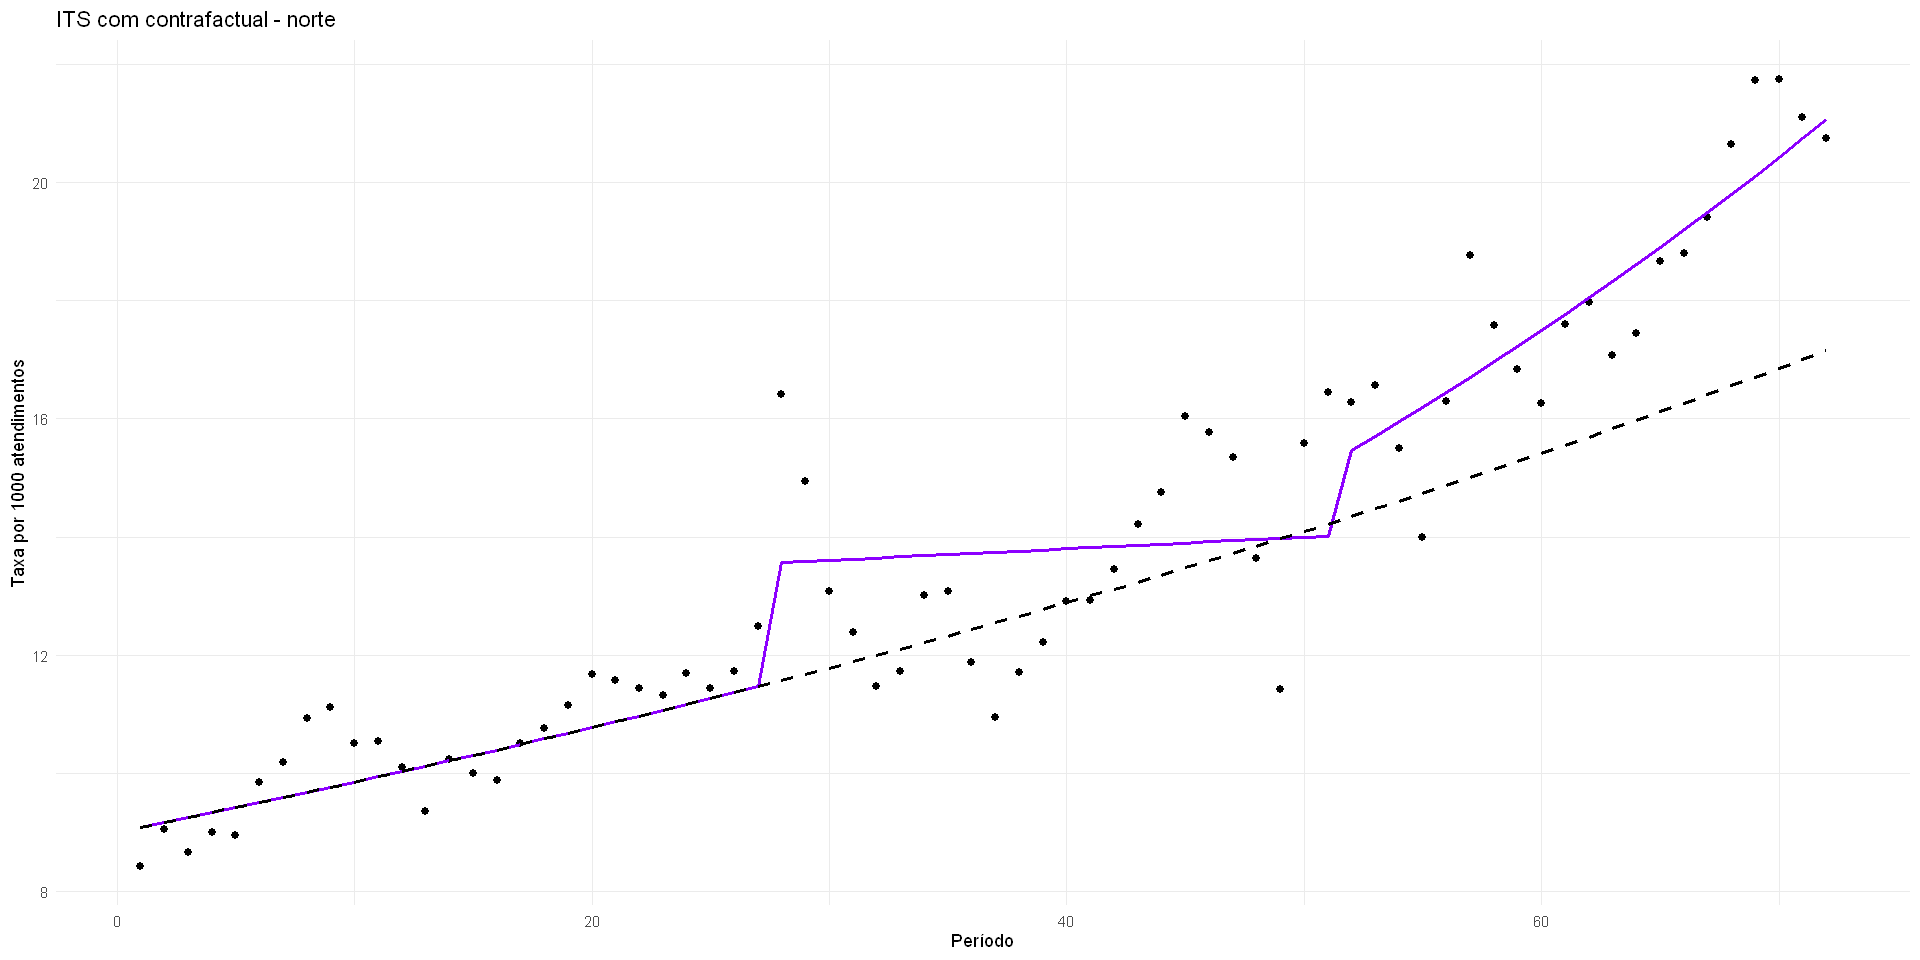

Plotando: sul 


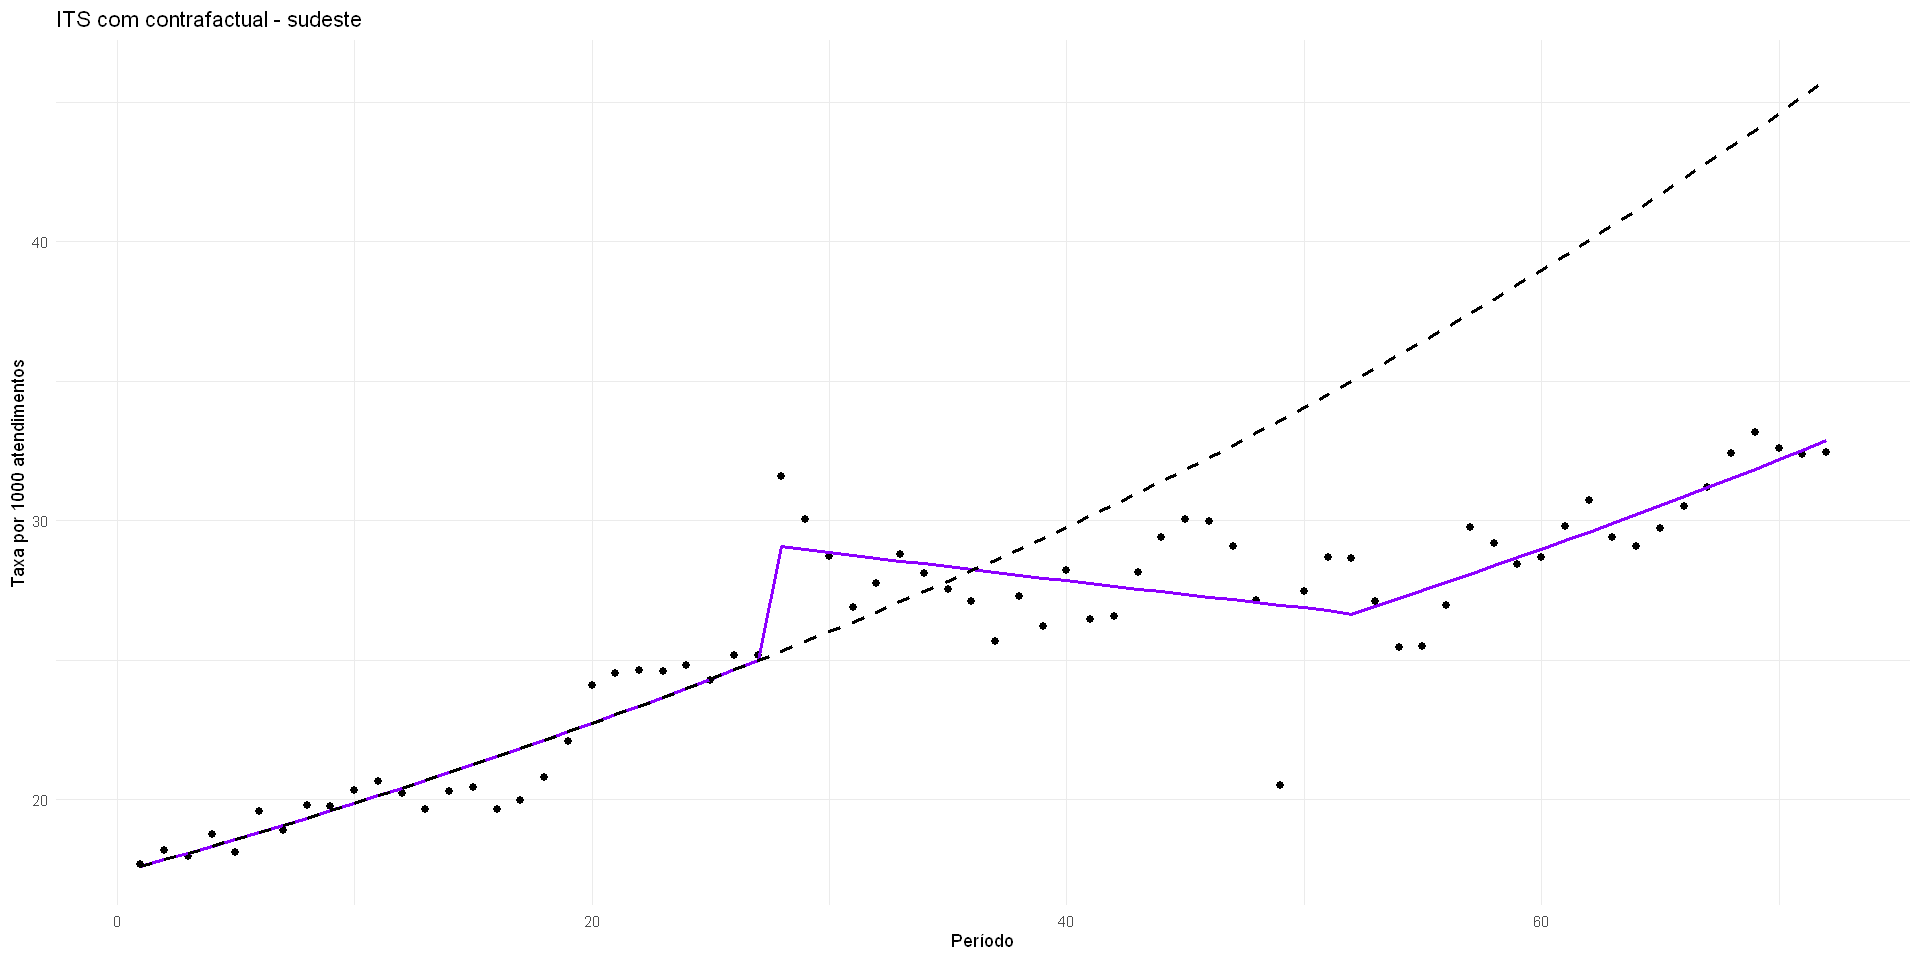

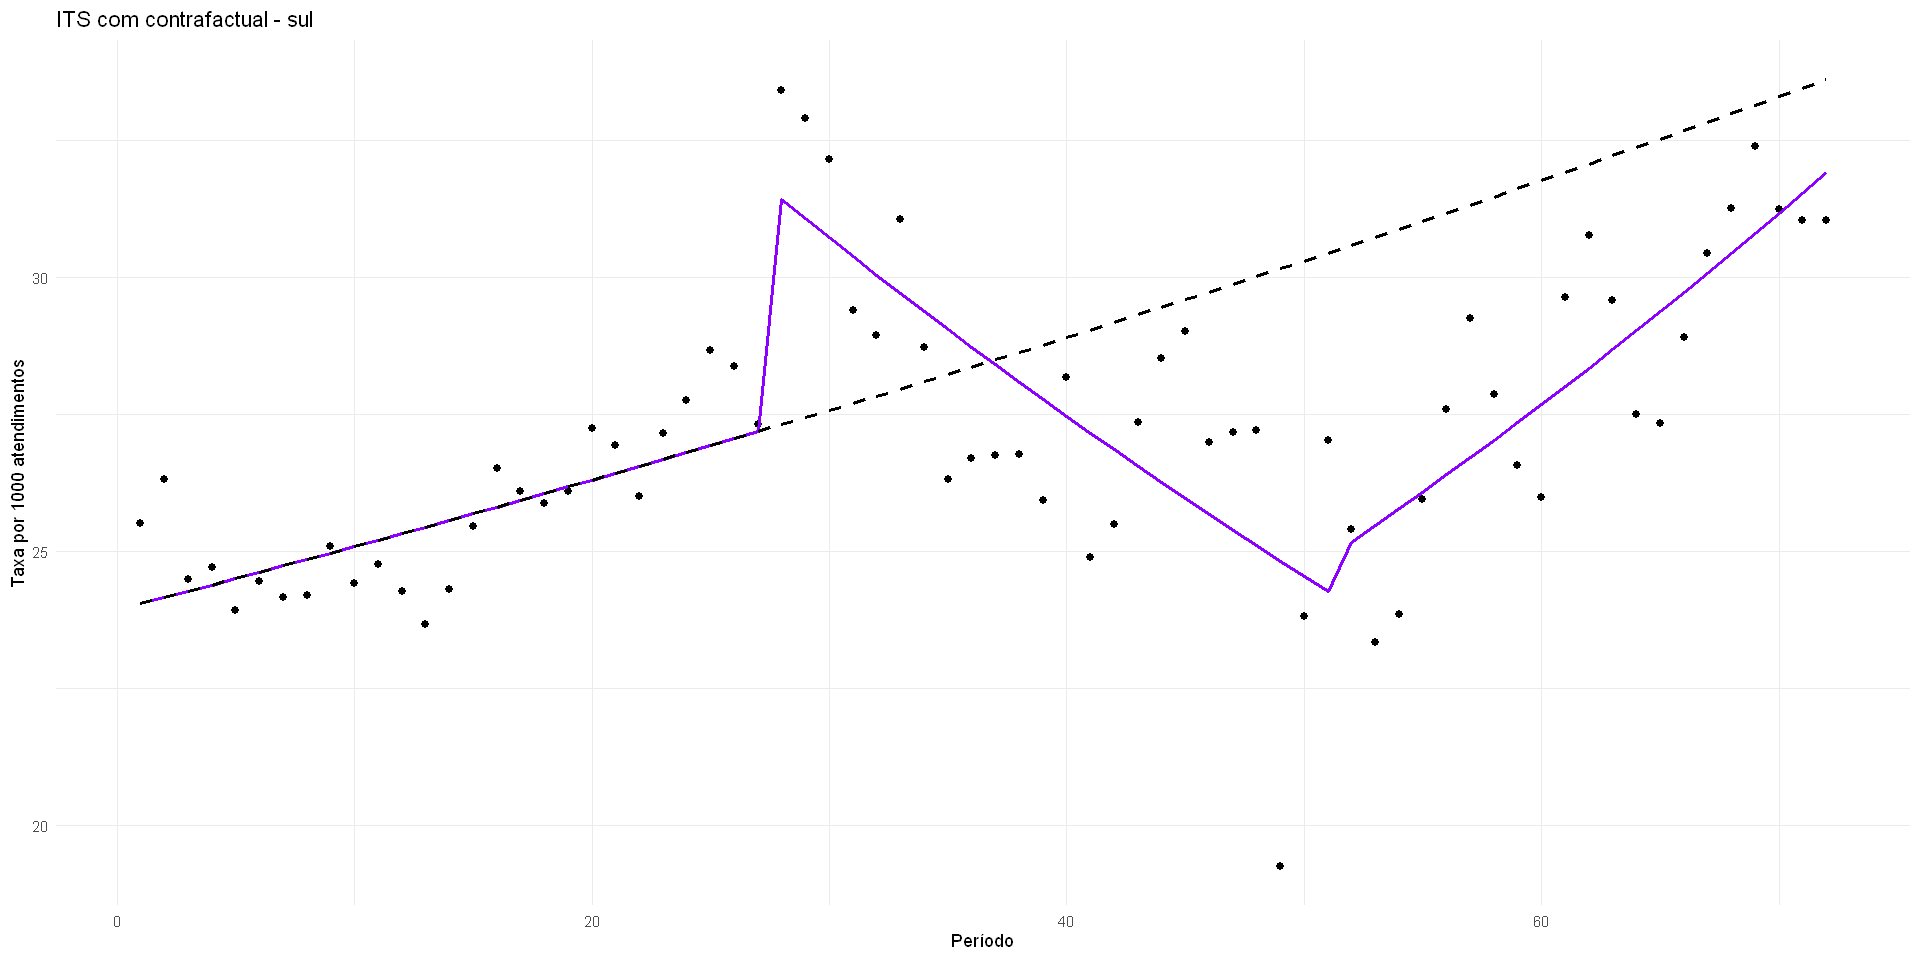

In [100]:
library(ggplot2)
library(dplyr)

for (reg in names(models_list)) {
  cat("Plotando:", reg, "\n")

  model <- models_list[[reg]]
  reg_data <- regression_df %>% filter(regiao == reg)
  reg_data$fitted <- fitted(model)

  coefs <- model$coefficients$fixed

  intercept <- coefs["(Intercept)"]
  b_time <- coefs["periodo"]
  b_pstep <- coefs["Pandemia_Step"]
  b_ptrend <- coefs["Pandemia_Trend"]
  b_poststep <- coefs["PosPandemia_Step"]
  b_posttrend <- coefs["PosPandemia_Trend"]

  reg_data <- reg_data %>%
    mutate(
      fase = case_when(
        PosPandemia_Step == 1 ~ "pos",
        Pandemia_Step == 1 ~ "pandemia",
        TRUE ~ "pre"
      ),
      predicted_segmented = case_when(
        fase == "pre" ~ exp(intercept + b_time * periodo),
        fase == "pandemia" ~ exp(intercept + b_pstep + b_time * periodo + b_ptrend * Pandemia_Trend),
        # fase == "pos" ~ exp(intercept + b_pstep + b_poststep + b_time * periodo +
        #                      b_ptrend * Pandemia_Trend + b_posttrend * PosPandemia_Trend)
        fase == "pos" ~ exp(intercept + b_poststep + b_time * periodo +
          +b_posttrend * PosPandemia_Trend)
      ),
      predicted_counterfactual = exp(intercept + b_time * periodo)
    )

  p <- ggplot(reg_data, aes(x = periodo)) +
    geom_point(aes(y = IR), color = "black", size = 2) +
    geom_line(aes(y = predicted_segmented), color = "#8c00ff", size = 1) +
    geom_line(aes(y = predicted_counterfactual), color = "#000000", linetype = "dashed", size = 1) +
    labs(
      title = paste("ITS com contrafactual -", reg),
      y = "Taxa por 1000 atendimentos",
      x = "Período"
    ) +
    theme_minimal()

  print(p)
}
